In [1]:
import pickle
from astropy.table import Table
from random import sample

from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

from pipeline_tools import *

Now, we will map the SOM positions from the deep field onto the SOM positions from the wide field. Here is the equation we will be using:

$$
p(z|\hat{c}) = \sum_{c} p(z|c,\hat{c}) p(c|\hat{c})
$$

i.e. in order to get the redshift given the wide SOM cell ($\hat{c}$), you sum the probability of the redshift given some mapping between $c$ and $\hat{c}$ times the probability of $c$ given $\hat{c}$ over all possible deep SOM cells $c$. 

In [2]:
# data loading
with open('../outputs/mock_assignments/simulations.pkl', 'rb') as f:
    d = pickle.load(f)
    
deep_positions = d['deep position']
wide_positions = d['wide positions']
wide_fluxes = d['wide fluxes']
z = d['z']

wm = [flux_to_mag(fi) for fi in wide_fluxes]
t = Table([deep_positions, wide_positions, wm, z], names=['Deep', 'Wide', 'Wide Magnitudes', 'Redshifts'])

ncells_deep = 48**2
ncells_wide = 22**2

# make a quick redshift cut
max_redshift=4
t = t[t['Redshifts']<max_redshift]

/Users/danecross/Desktop/SOMs/SOM-photoz-BFD/src/pipeline_tools.py:6: RuntimeWarning: invalid value encountered in log10
  return -2.5 * np.log10(f) + const


# Get $p(c|\hat{c})$

This is done by adding together all of the wide field classifications that are associated with a single deep field cell and normalizing so that adding all of the wide cell bins associated with one deep cell gives one. 

In [3]:
# fill pcchat with the probability of the wide cell given the deep cell
pcchat = np.zeros((ncells_deep,ncells_wide))
for dc,wc in zip(t['Deep'], t['Wide']):
    pcchat[int(dc),:] += np.histogram(wc, bins=ncells_wide, range=(0,ncells_wide))[0]

# normalize
empty_count = 0
for i,_ in enumerate(pcchat.T):
    pcchat[:,i] = pcchat[:, i]/np.sum(pcchat[:,i])

pcchat = np.nan_to_num(pcchat)
print(np.sum(pcchat), pcchat.shape) # << if correctly normalized, should sum to 484 (= 22*22)

483.99999999999994 (2304, 484)


### Quick Sanity Check
This plot some examples of mapping between one deep cell and the corresponding wide cell

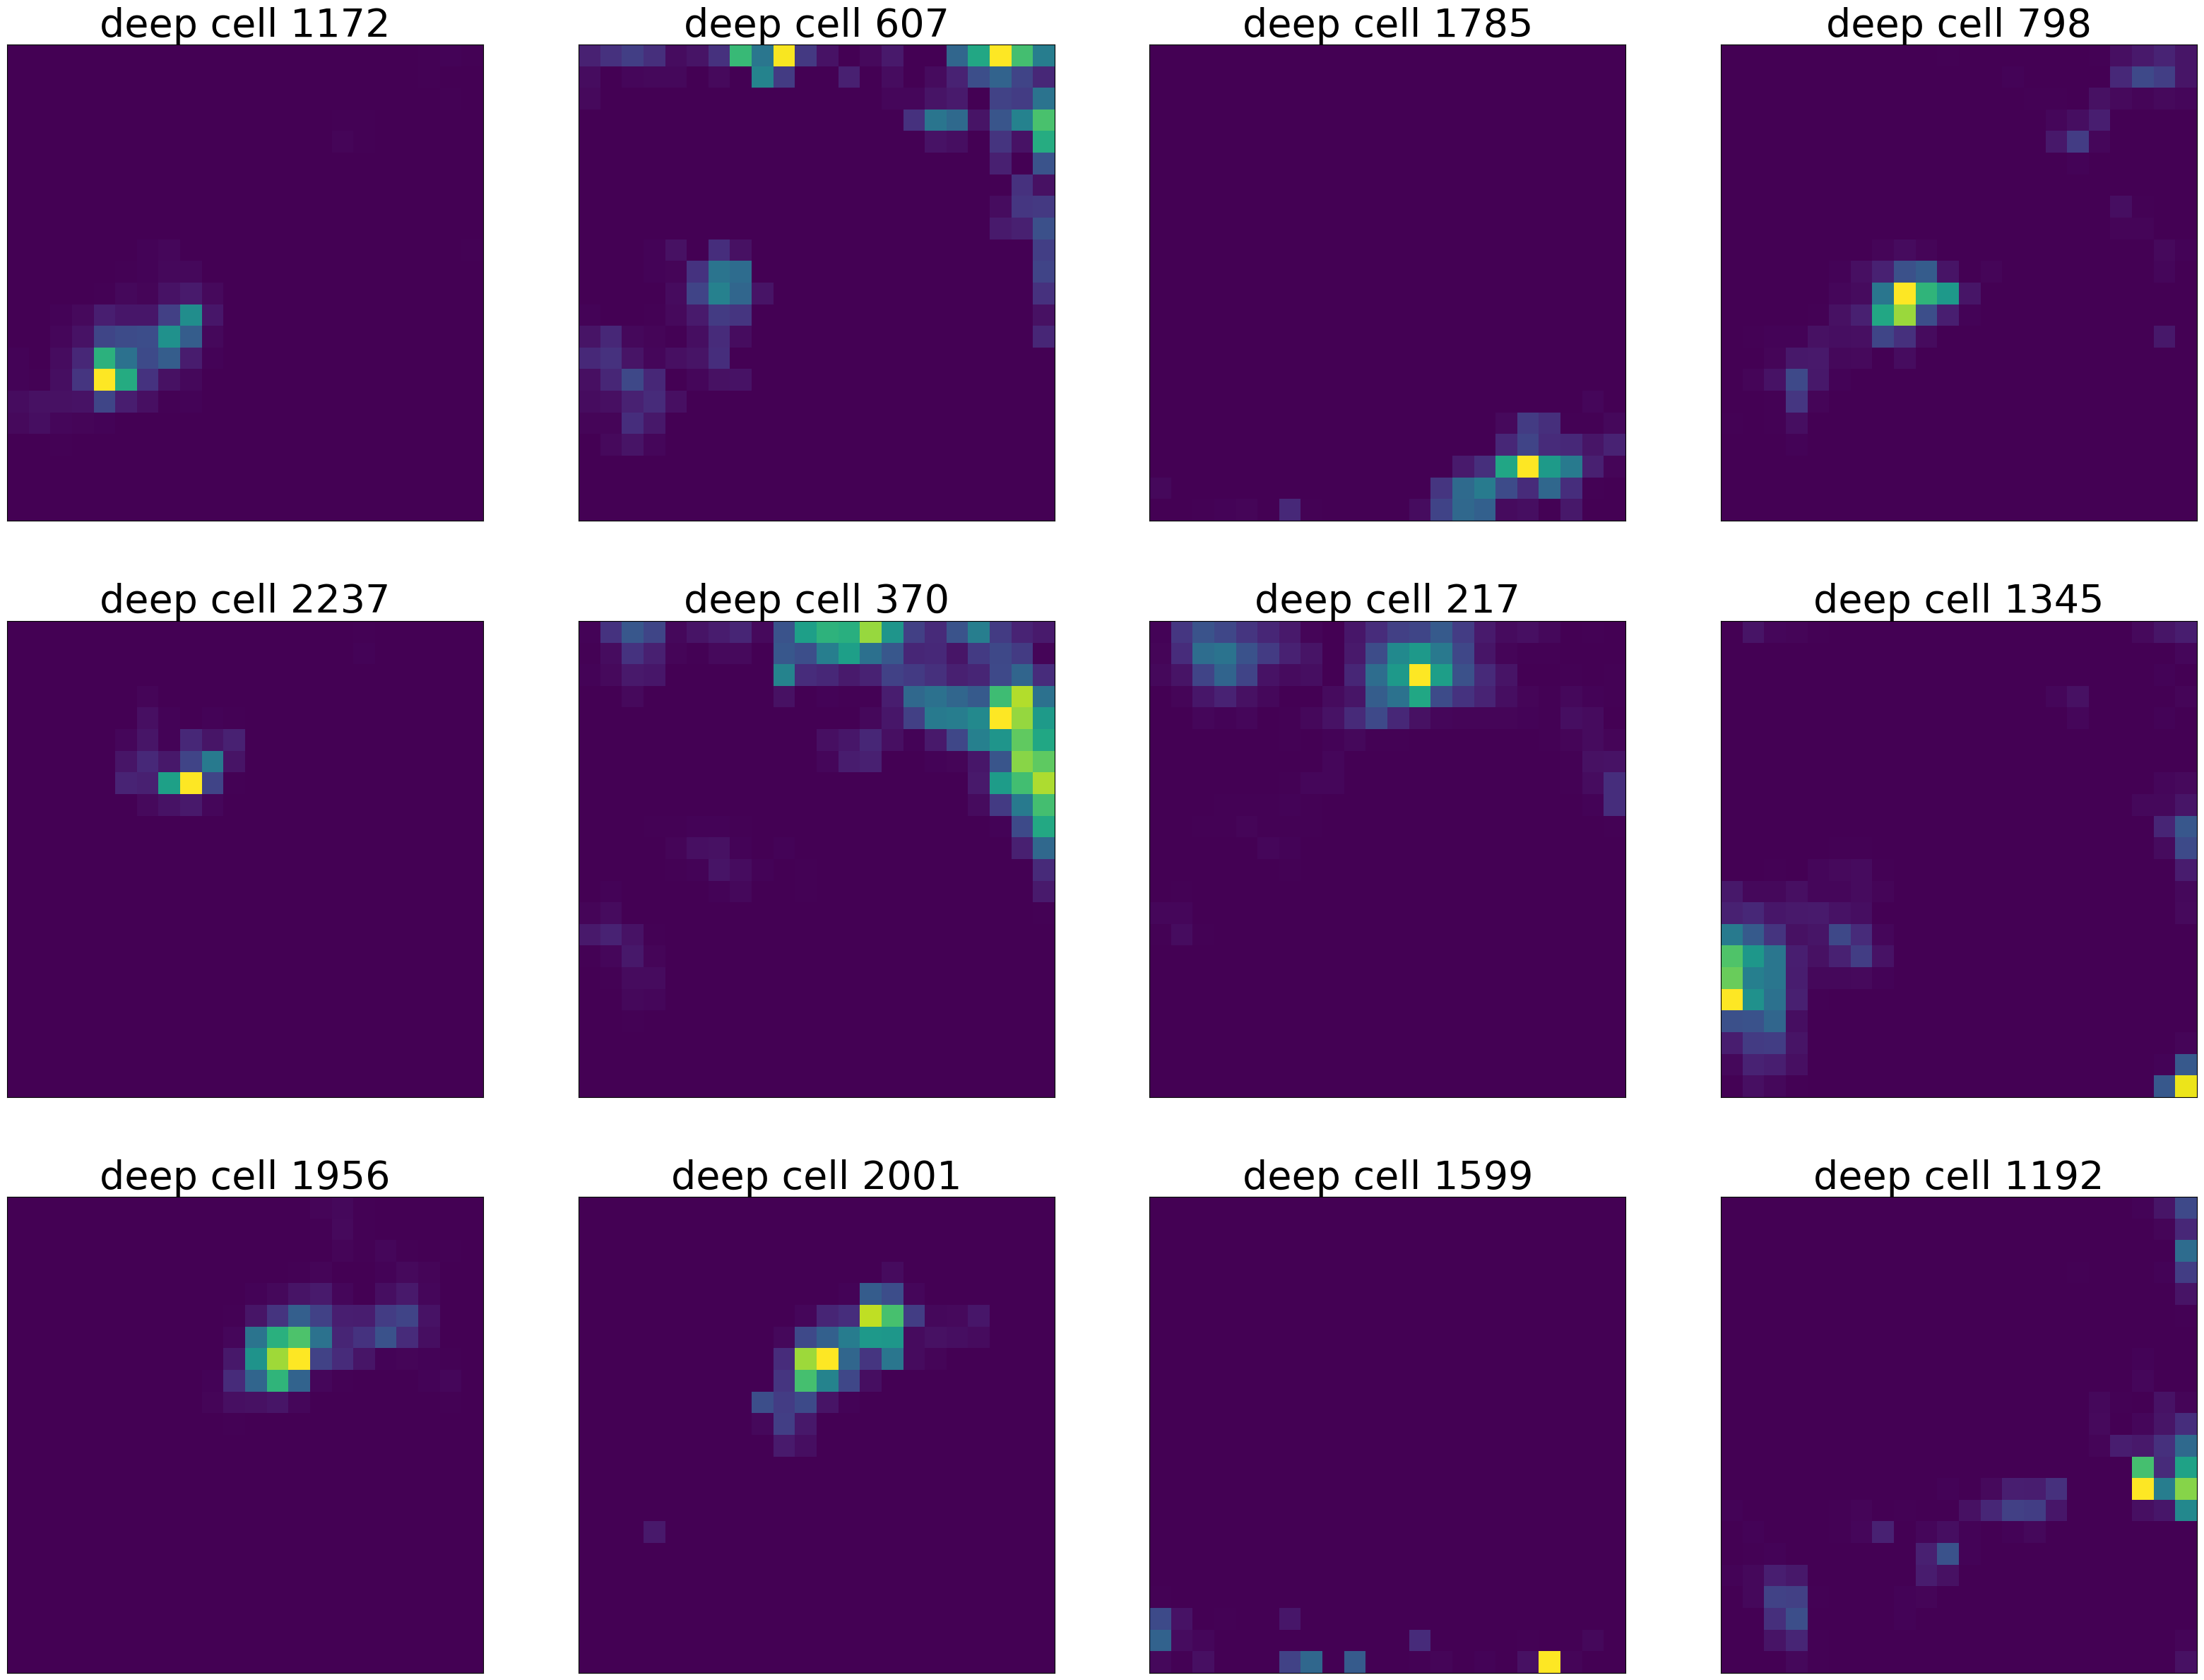

In [4]:
fig, axs = plt.subplots(3,4, figsize=(40,30))
_max = -np.inf ; _min = np.inf
for i,idx in enumerate(sample(range(ncells_deep), 12)):
    mapping = pcchat[idx]
    wide_occupation = mapping.reshape((22,22))

    axs[i%3,i%4].set_title("deep cell %i"%idx, fontsize=40)
    im = axs[i%3,i%4].imshow(wide_occupation)
    
    axs[i%3,i%4].set_xticks([]) ; axs[i%3,i%4].set_yticks([])
    
plt.show()

# Get p(z|c,c\hat)

Making 48\*48 histograms of the redshift distributions for each deep field cell

In [5]:
num_zbins = 150 ; zrange = (0,max_redshift)

cz = [np.array([])]*ncells_deep 
for row in t:
    cz[int(row['Deep'])] = np.append(cz[int(row['Deep'])], [row['Redshifts']])
    
pzc_unnormed = np.zeros((num_zbins, ncells_deep)) 
pzc = np.zeros((num_zbins, ncells_deep)) 
for i in range(ncells_deep):
    pzc[:,i] = np.histogram(cz[i], num_zbins, range=zrange)[0]/len(cz[i])
    pzc_unnormed[:,i] = np.histogram(cz[i], num_zbins, range=zrange)[0]
    
pzc = np.nan_to_num(pzc)
print(np.nansum(pzc), pzc.shape) # << should sum to the number of occupied deep cells (<= 2304)

2301.0000000000005 (150, 2304)


/var/folders/nt/7hp8jjq563b09vy01vqx17dh0000gn/T/ipykernel_930/2595283080.py:10: RuntimeWarning: invalid value encountered in true_divide
  pzc[:,i] = np.histogram(cz[i], num_zbins, range=zrange)[0]/len(cz[i])


### Sanity Check
Check out the redshift distribution of a set of random deep cells

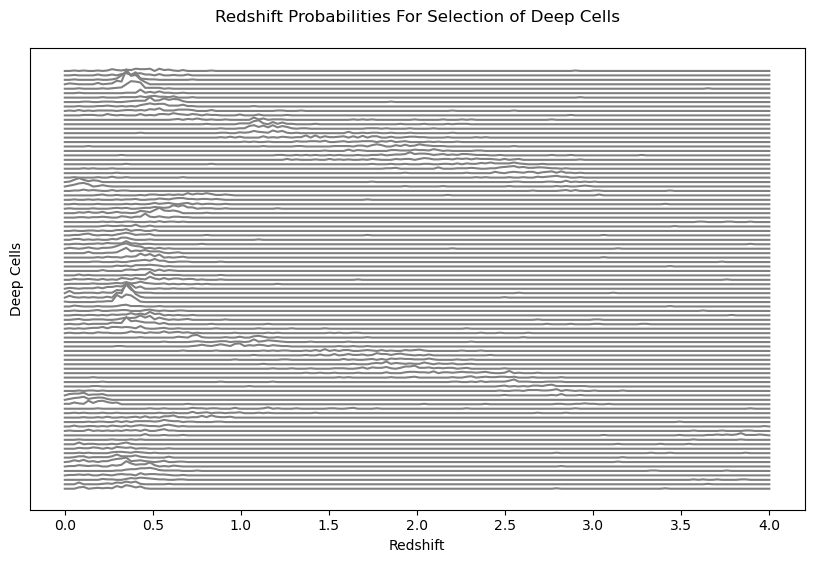

In [6]:
redshifts = np.linspace(zrange[0], zrange[1], num_zbins)
for i,poss in enumerate(pzc_unnormed.T):
    if i > 48*3-20 and i < 48*5-20:
        plt.plot(redshifts, float(i*10)+poss, color='gray')

plt.ylabel('Deep Cells')
plt.xlabel('Redshift')
plt.title("Redshift Probabilities For Selection of Deep Cells\n")
plt.yticks([])#([i*10 for i in range(48*3-20, 48*4-20) if i%20==0], [i for i in range(48*3-20, 48*4-20) if i%20==0])
plt.gcf().set_size_inches((10,6))
plt.show()

# get p(z|chat)

Now we perform the $p(z|\hat{c}) = \sum_{c} p(z|c,\hat{c}) p(c|\hat{c})$ calculation

In [7]:
print(pzc.shape, pcchat.shape)
pzchat = np.einsum('zt,td->dz', pzc, pcchat)
print(pzchat.shape)
print(np.nansum(pzchat, axis=1)) # << should be a bunch of ones

(150, 2304) (2304, 484)
(484, 150)
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 

In [8]:
np.save('../outputs/p_z_chat/BFD_v1', pzchat)

masks = [t['Deep']==binnum for binnum in range(ncells_wide)]
pzchat_weights = np.array([len(t['Redshifts'][mask]) for mask in masks])
np.save('../outputs/p_z_chat/BFD_v1_weights', pzchat_weights)

In [9]:
pzchat.shape

(484, 150)

In [ ]:
cell_range = (0, len(pzchat)) ; yspacing = 20
redshifts = np.linspace(zrange[0], zrange[1], num_zbins)
for i,poss in enumerate(pzchat):
    if i > cell_range[0] and i < cell_range[1]:
        plt.plot(redshifts, float(i*10)+100*poss)

plt.ylabel('Wide Cells')
plt.xlabel('Redshift')
plt.title("Redshift Probabilities For Each Wide Cell\n")
plt.yticks([i*10 for i in range(*cell_range) if i%yspacing==0], 
           [i for i in range(*cell_range) if i%yspacing==0])
plt.gcf().set_size_inches((10,45))
plt.ylim((0,len(pzchat)*10))
plt.xlim((redshifts[0], redshifts[-1]))
plt.show()

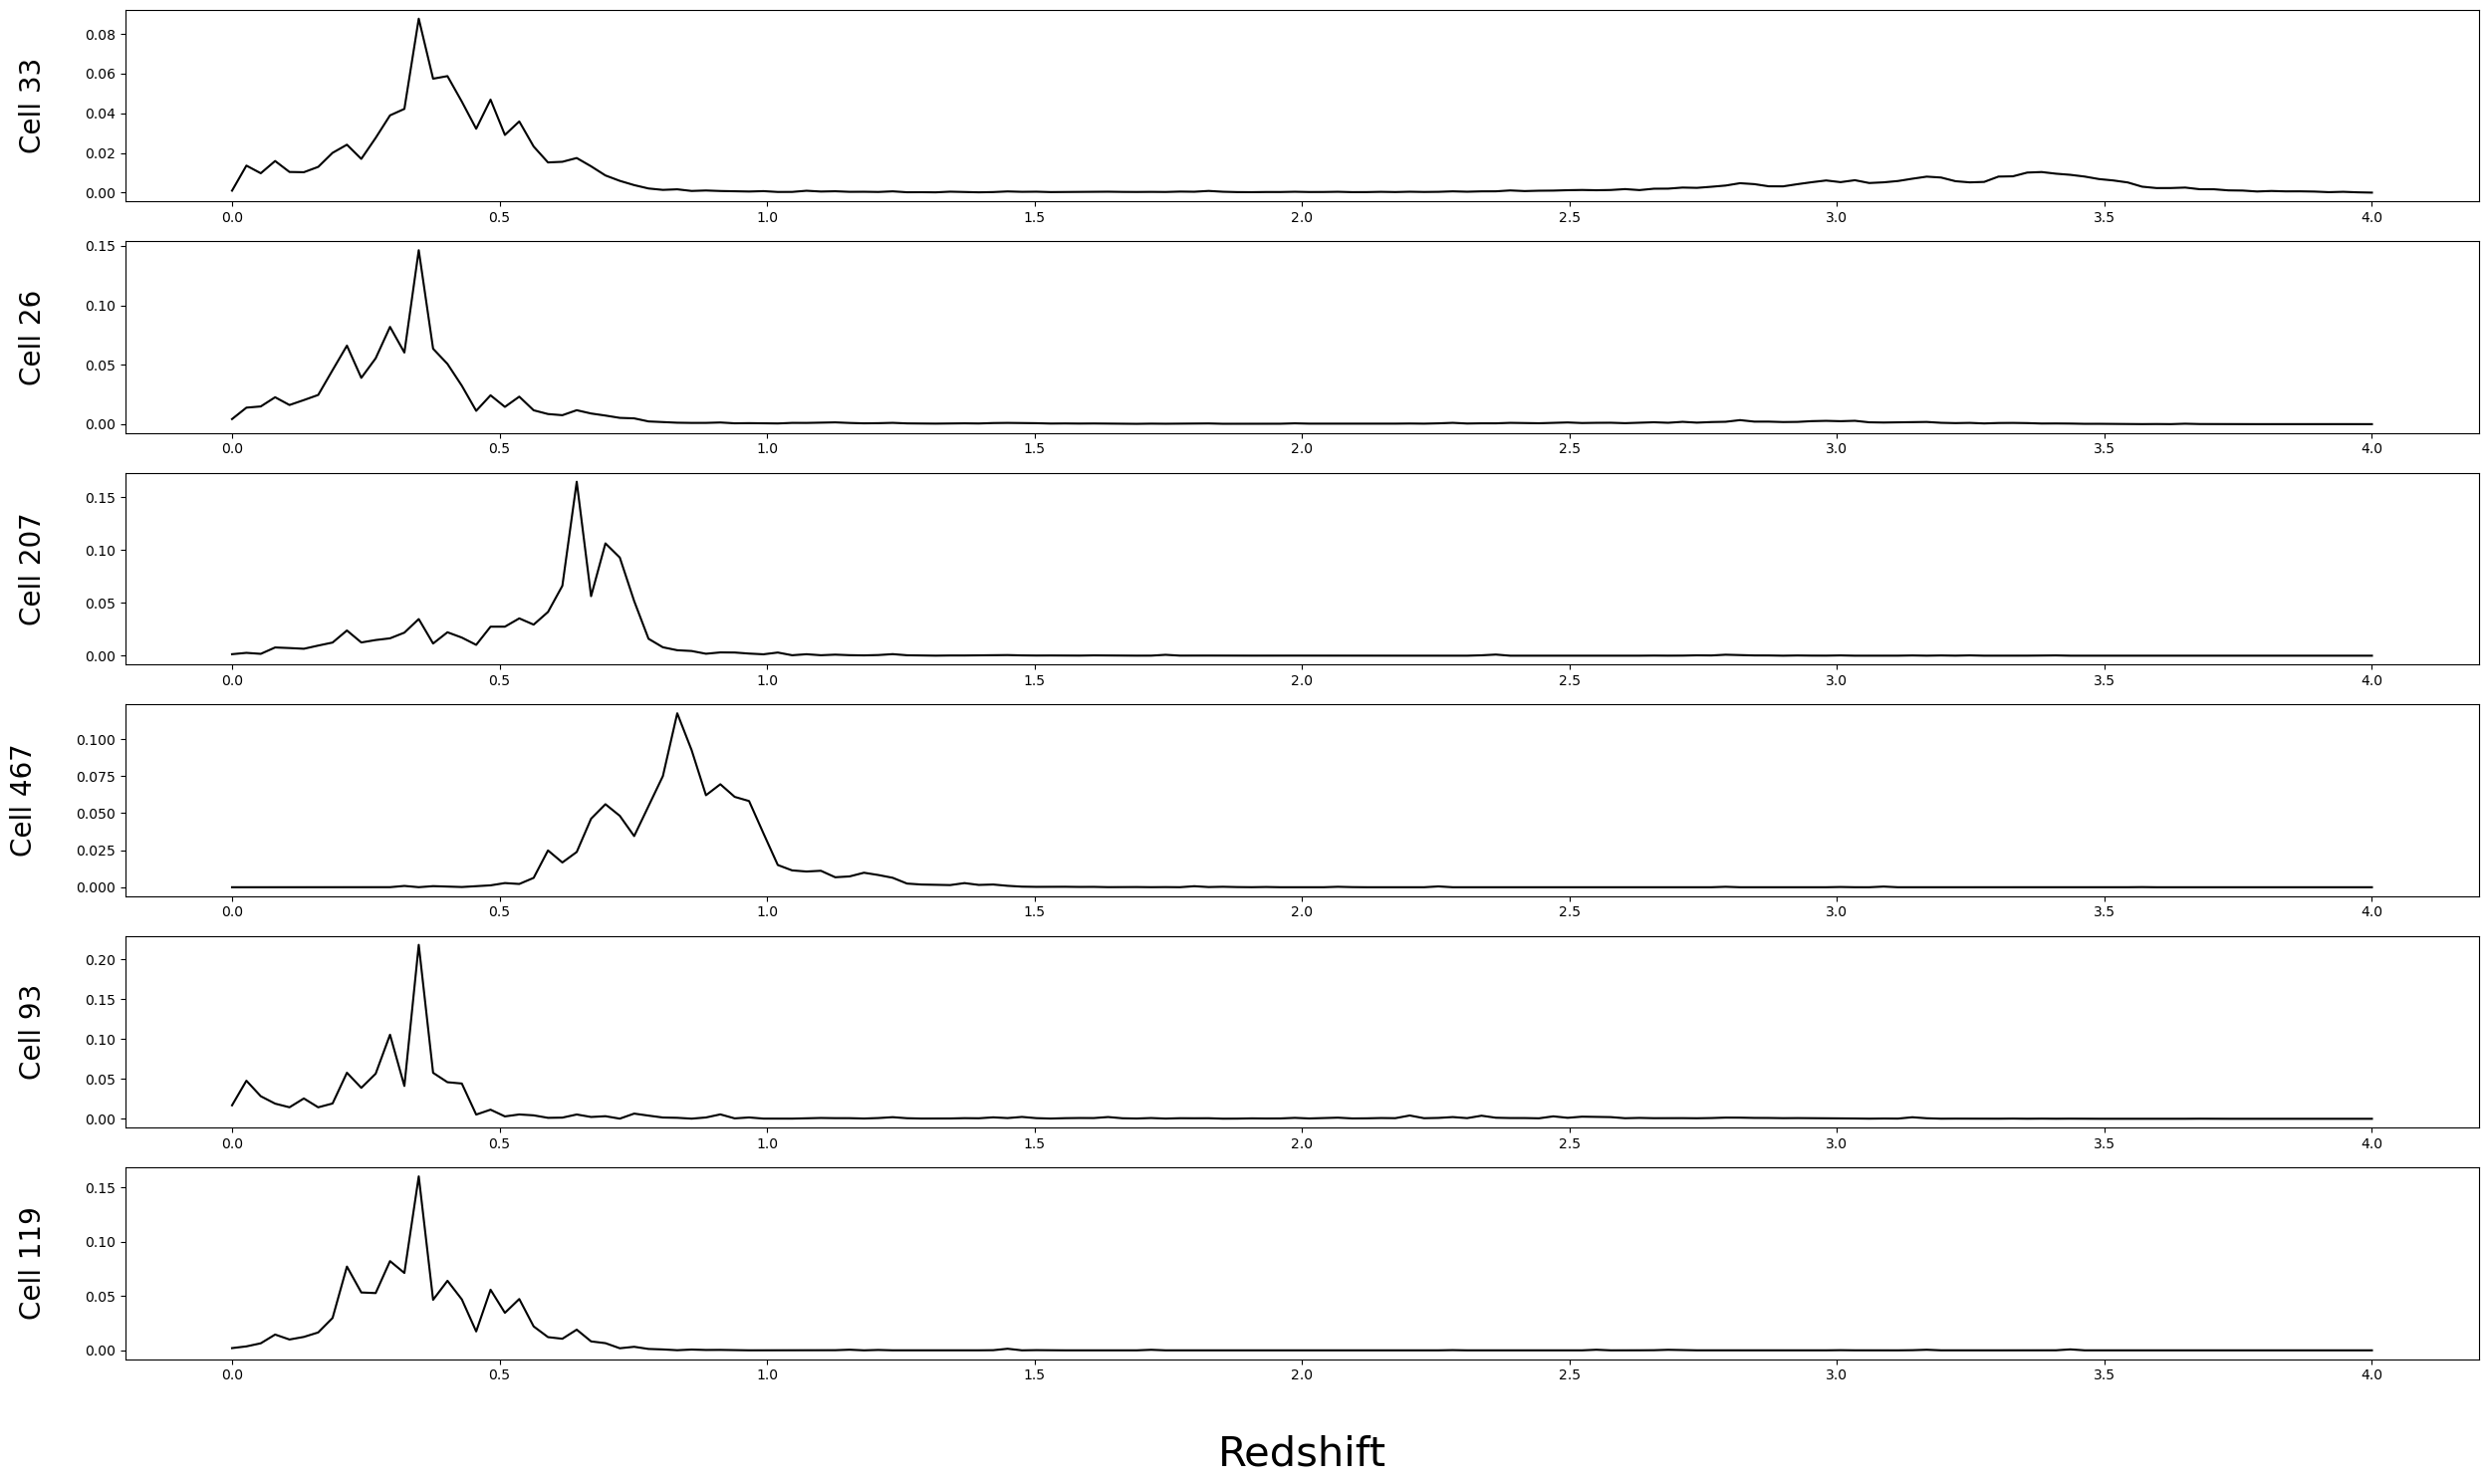

In [11]:
fig, axs = plt.subplots(6, figsize=(25,15)) 
redshifts = np.linspace(zrange[0], zrange[1], num_zbins)

cells = np.random.randint(0,len(pzchat), 6)
[ax.plot(redshifts, pzchat[cell], color='black') for ax, cell in zip(axs,cells)]
[ax.set_ylabel("Cell %i\n"%cell, fontsize=20) for ax, cell in zip(axs, cells)]
axs[-1].set_xlabel('\nRedshift', fontsize=30) 

fig.tight_layout()
plt.show()

To get the redshift mapping, we have to find the expectation value of the redshift for each given cell. This is done by:

$$
\left\langle z \right\rangle = \frac{\sum_{z}z P(z|\hat{c}) }{\sum_{z}P(z|\hat{c})}
$$

In [12]:
def E(v, pv):
    return np.array([np.average(v, weights=p) if np.sum(p)>0 else np.nan for p in pv])

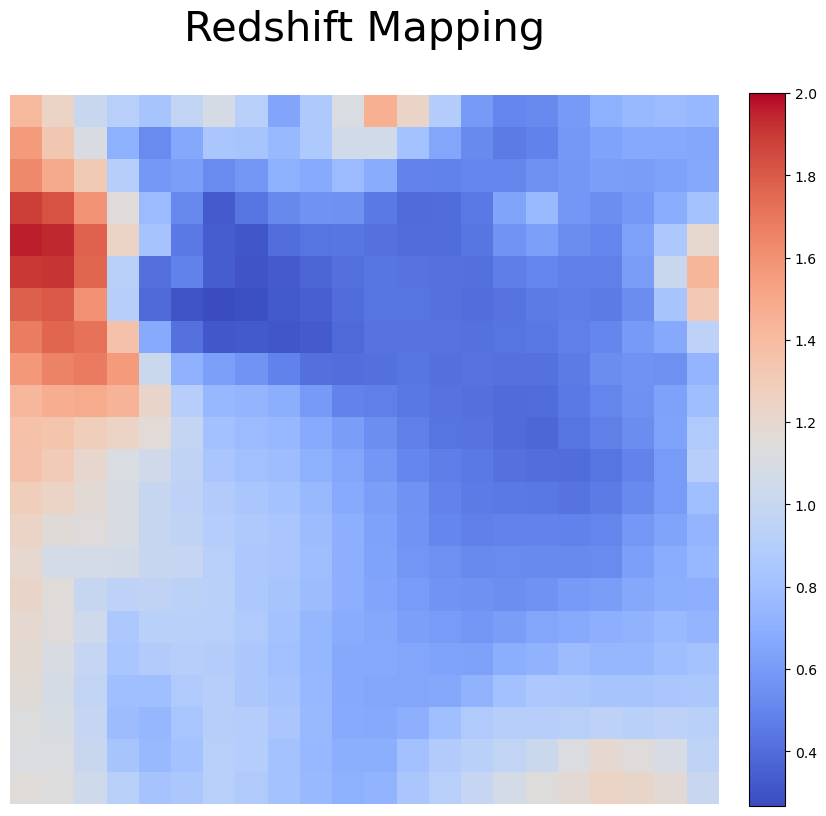

In [13]:
peak_probs = E(redshifts, pzchat)
plt.imshow(peak_probs.reshape(22,22), cmap='coolwarm', vmax=2.0)
plt.axis('off')

plt.title('Redshift Mapping\n', fontsize=30)
plt.gcf().set_size_inches((10,10))
plt.colorbar(fraction=0.046, pad=0.04)
plt.show()

## Statistics on the Redshift Mapping

First, we want to see the width of the distrubutions in each cell:
$$
\Delta z = \left\langle \left\langle z^2 \right\rangle - \left\langle z \right\rangle^2\right\rangle 
$$

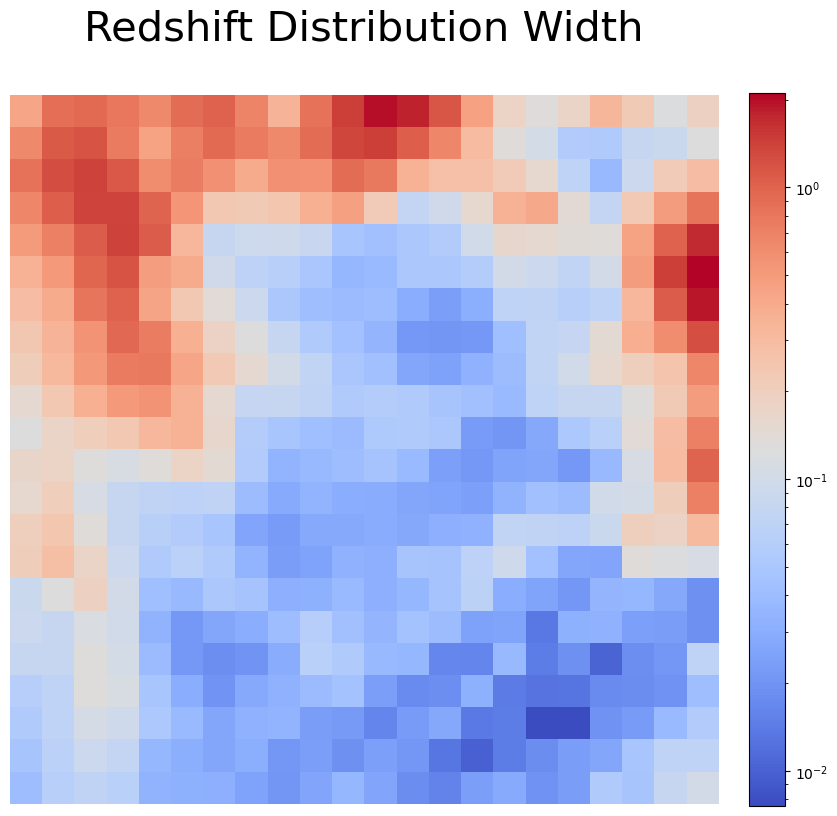

In [14]:
std_z = E(redshifts**2, pzchat) - E(redshifts, pzchat)**2
plt.imshow(std_z.reshape(22,22), cmap='coolwarm', norm=LogNorm())
plt.axis('off')

plt.title('Redshift Distribution Width\n', fontsize=30)
plt.gcf().set_size_inches((10,10))
plt.colorbar(fraction=0.046, pad=0.04)
plt.show()

In [15]:
np.save('../outputs/p_z_chat/BFD_v1_avg', peak_probs)
np.save('../outputs/p_z_chat/BFD_v1_std', std_z)
np.save('../outputs/p_z_chat/redshifts', redshifts)

## Distribution Width as a Function of i-band magnitude

In [16]:
chat_imag = [np.array([])]*ncells_wide
for row in t:
    for chat, mags in zip(row['Wide'], row['Wide Magnitudes']):
        chat_imag[chat] = np.append(chat_imag[chat], mags[1])

In [17]:
avg = [np.average(mag_arr) for mag_arr in chat_imag]
std = [np.std(mag_arr) for mag_arr in chat_imag]

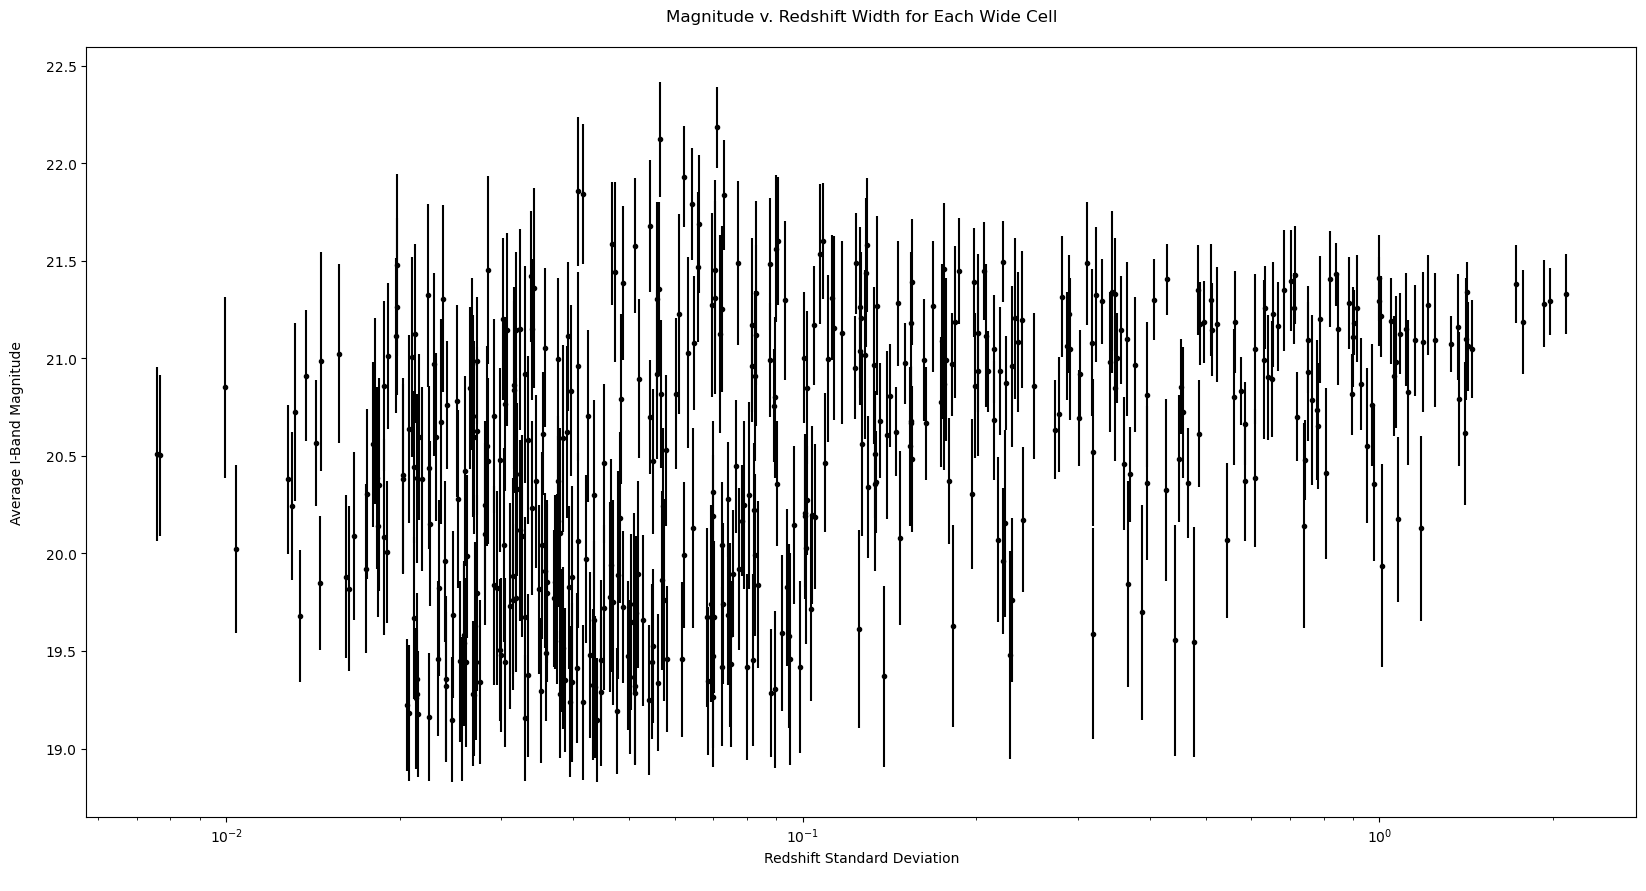

In [18]:
plt.errorbar(std_z, avg, yerr=std, fmt='.', color='black')
plt.title('Magnitude v. Redshift Width for Each Wide Cell\n')
plt.ylabel('Average I-Band Magnitude\n')
plt.xlabel('Redshift Standard Deviation\n')
plt.xscale('log')
plt.gcf().set_size_inches((20,10))

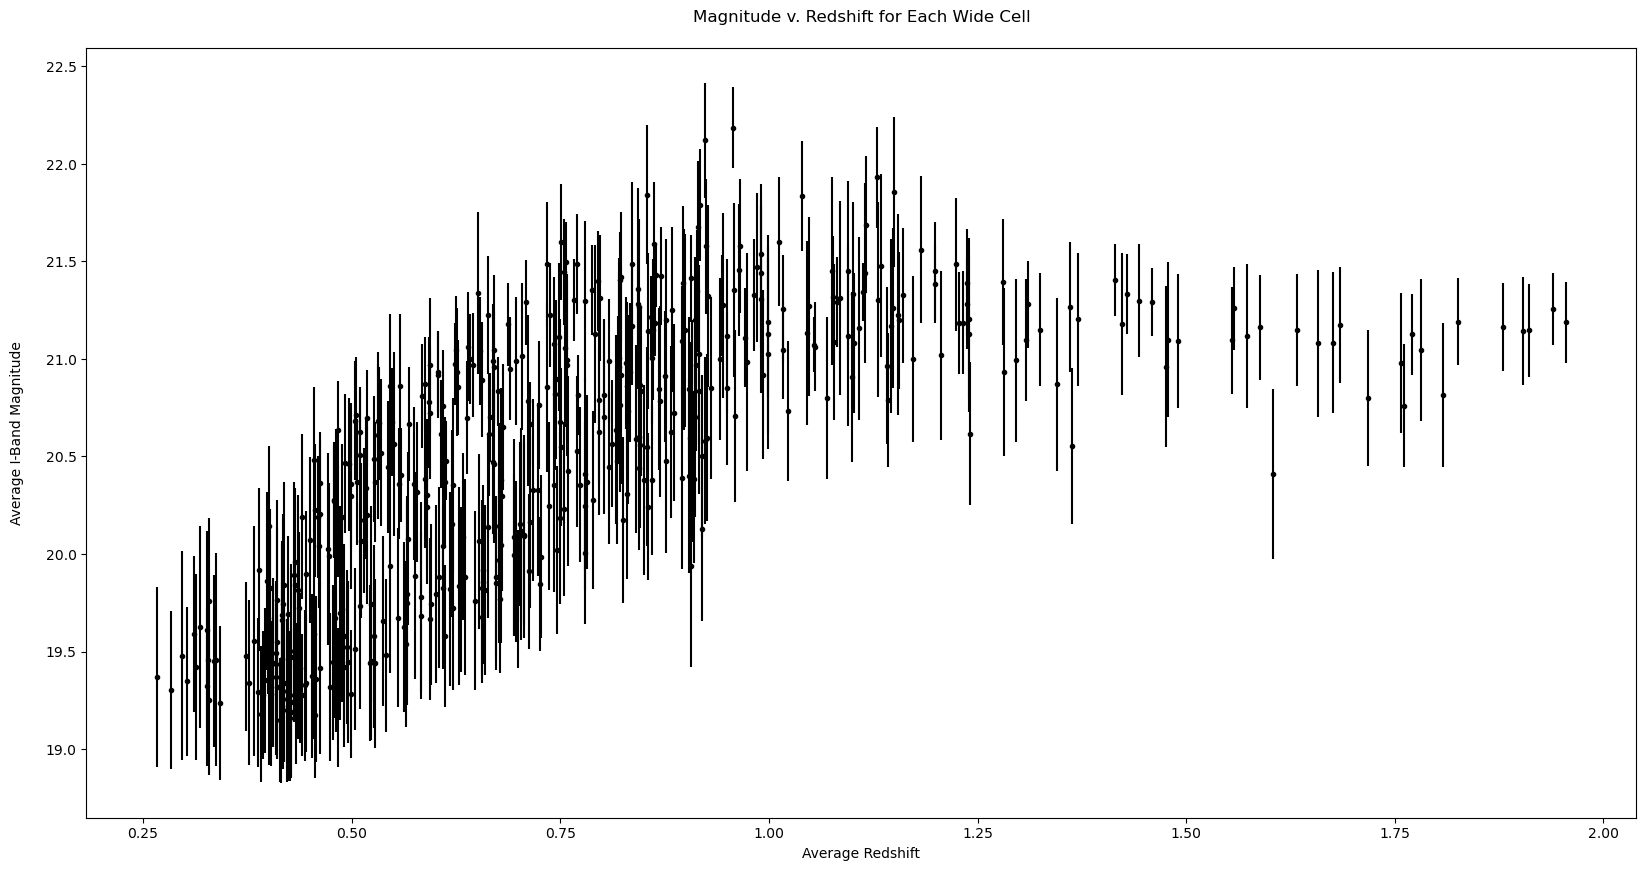

In [19]:
plt.errorbar(peak_probs, avg, yerr=std, fmt='.', color='black')
plt.title('Magnitude v. Redshift for Each Wide Cell\n')
plt.ylabel('Average I-Band Magnitude\n')
plt.xlabel('Average Redshift\n')
plt.gcf().set_size_inches((20,10))